In [2]:
from ultralytics import YOLO
import torch
model=YOLO()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [5]:
torch.cuda.is_available()

True

In [5]:
print(torch.__version__)

2.3.0+cu121


In [7]:
#training the model 
# result=model.train(data='data.yaml',epochs=100,patience=10,imgsz=640)
#skipping as the model is already trained

In [3]:
#loading the saved weights from training
model=YOLO('.\\runs\\detect\\train3\\weights\\best.pt')

In [3]:
#visualizing the detection and image
import os 
import cv2
from matplotlib import pyplot as plt
import albumentations as A  

Box_color=(255,0,0)#red
Text_color=(255,255,255)#white
def visualize_bbox(img, bbox, class_name, color=Box_color, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_c,y_c,w,h=bbox # in normalized form
    H,W,_=img.shape
    x_center,y_center,width,height=x_c*W,y_c*H,w*W,h*H
    x_min =int( x_center - 0.5 * width)
    y_min = int(y_center - 0.5 * height)
    x_max = int(x_center + 0.5 * width)
    y_max = int(y_center + 0.5 * height)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.5 * text_height)), (x_min + text_width, y_min), Box_color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.5,
        color=Text_color,
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image,bboxes,category_ids,category_id_to_name):
    img=image.copy()
    for bbox,category_id in zip(bboxes,category_ids):
        class_name=category_id_to_name
        img=visualize_bbox(img,bbox,class_name)
    # os.makedirs('agumented',exist_ok=True)
    # cv2.imwrite()
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(img)

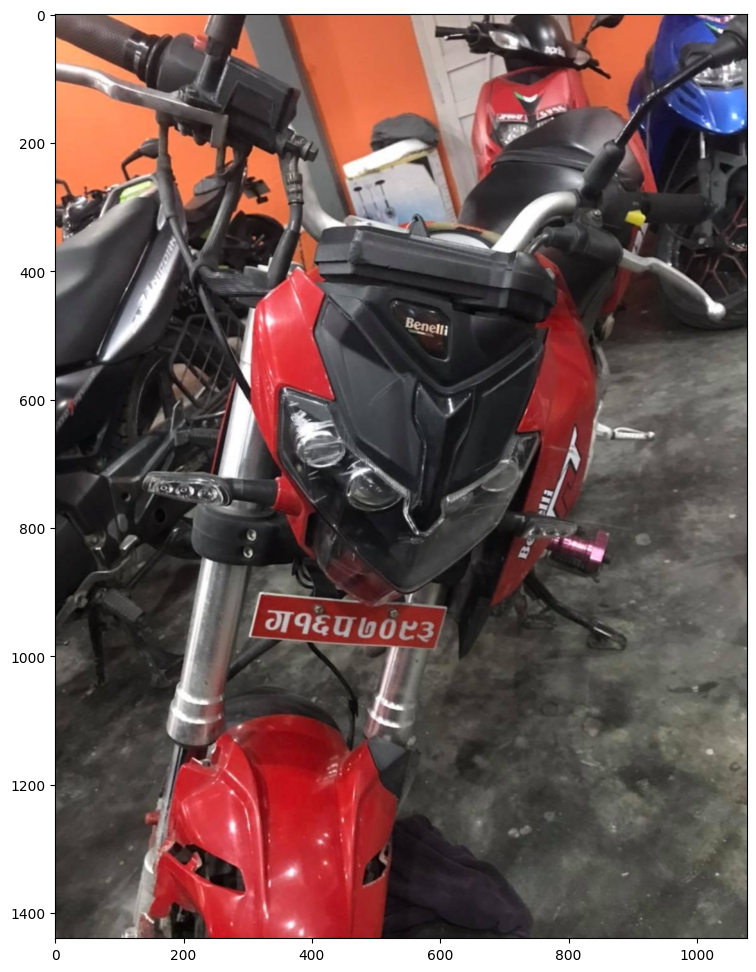

In [10]:
#test image to visualize the detection
%matplotlib inline
image=cv2.imread('AV1_bike_84_1_107uuTBZ2097.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

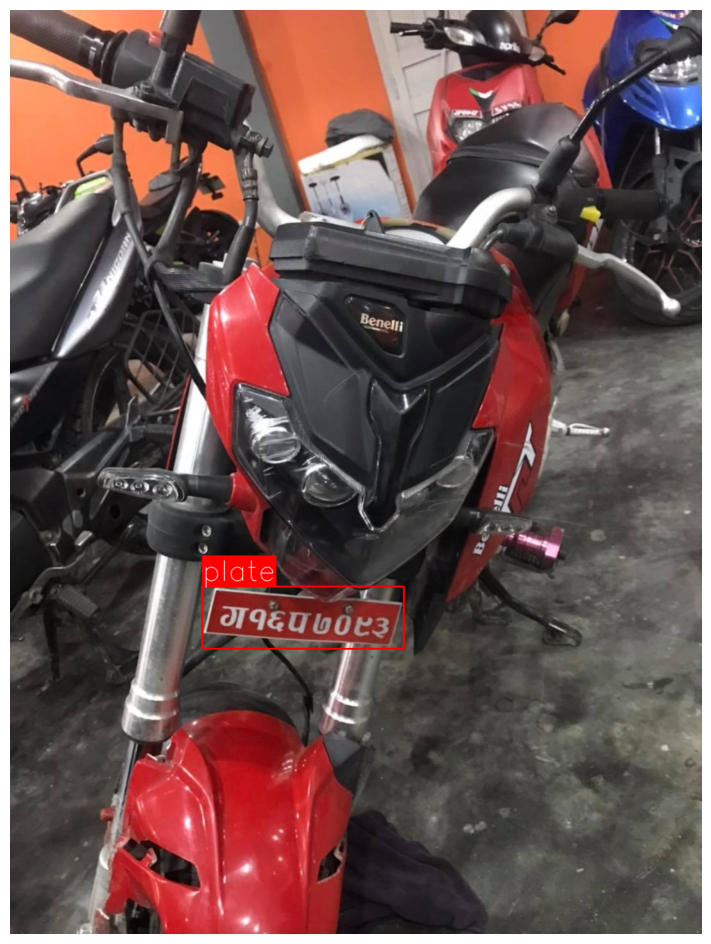

In [11]:
#visualizing the detection
bboxes=[[0.423006, 0.657292, 0.291280, 0.067361]]
category_ids=[0]
category_id_to_name={0 : 'plate'}
visualize(image,bboxes,category_ids,category_id_to_name)

In [4]:
#agumenting the image using transform pipeline
transform=A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RGBShift(r_shift_limit=30,g_shift_limit=30,b_shift_limit=30,p=0.3),
    A.Blur(blur_limit=3)
],
bbox_params=A.BboxParams(format='yolo',label_fields=['category_ids'])
)

In [14]:
#applying transform function on test image
transformed=transform(image=image,bboxes=bboxes,category_ids=category_ids)

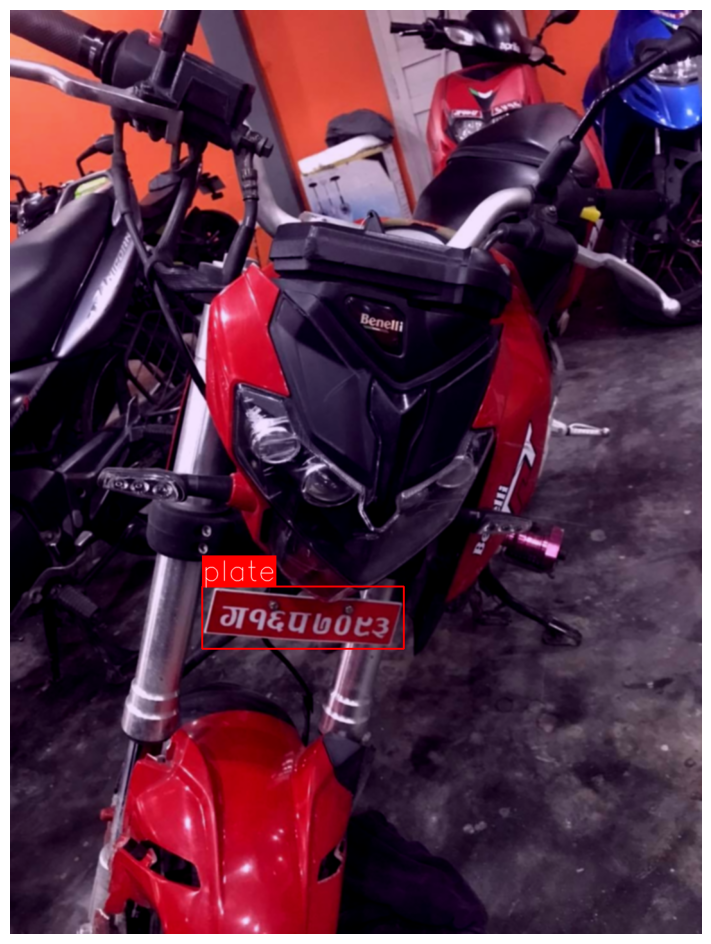

In [15]:
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name
)

In [16]:
#creating a csv file of all the image detail like path , bounding box
image_folder='./datasets/train_subset/images'
label_folder='./datasets/train_subset/labels'

import csv
fields=['ImagePath','ClassLabel','Xcenter','Ycenter','width','height']
with open('train', 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)

for image_filename in os.listdir(image_folder):    
    if image_filename.endswith('.jpg'):
        image_path=os.path.join(image_folder,image_filename)
        label_filename=image_filename.replace('.jpg','.txt')
        label_path=os.path.join(label_folder,label_filename)
        image=cv2.imread(image_path)
        image_height,image_width,_=image.shape
        with open(label_path,'r') as label_file:
            for line in label_file:
                class_id,x_center,y_center,width,height=map(float,line.split())
                row=[image_path,class_id,x_center,y_center,width,height]
                with open('train', 'a') as f: 
                    write = csv.writer(f)       
                    write.writerow(row)

In [8]:
#loading the csv file
import pandas as pd
df=pd.read_csv('train.csv')
df

,ImagePath,ClassLabel,Xcenter,Ycenter,width,height
0,./datasets/train_subset/images\agumented_01965...,3.0,0.419929,0.773132,0.301305,0.113879
1,./datasets/train_subset/images\agumented_020e2...,1.0,0.663889,0.762500,0.086111,0.066667
2,./datasets/train_subset/images\agumented_02510...,3.0,0.558984,0.788194,0.071094,0.095833
3,./datasets/train_subset/images\agumented_04b54...,3.0,0.389062,0.809259,0.190625,0.214815
4,./datasets/train_subset/images\agumented_05f97...,3.0,0.224479,0.537684,0.119792,0.148897
...,...,...,...,...,...,...
711,./datasets/train_subset/images\imboost_6.jpg,0.0,0.691250,0.332500,0.277500,0.062500
712,./datasets/train_subset/images\imboost_60.jpg,3.0,0.321528,0.803125,0.256944,0.068750
713,./datasets/train_subset/images\imboost_7.jpg,0.0,0.889167,0.765625,0.221667,0.163750
714,./datasets/train_subset/images\imboost_8.jpg,0.0,0.476250,0.331875,0.327500,0.071250


In [18]:
df.dtypes

ImagePath      object
ClassLabel    float64
Xcenter       float64
Ycenter       float64
width         float64
height        float64
dtype: object

In [20]:
#Generating new names for the agumented files 
import uuid
import datetime

def generate_random_string(length=6):
    return str(uuid.uuid4())[:length]

def new_name(transformed):
    timestamp=datetime.datetime.now().strftime("%Y%m%D_%H%M%S")
    random_string=generate_random_string()
    filename_image=f'agumented_{random_string}.jpg'
    filename_label=filename_image.replace('.jpg','.txt')
    return filename_image,filename_label

In [ ]:
#saving agumnted images with random file name generated by calling new name file
from PIL import Image
import numpy as np

category_id_to_name={0: 'plate',1: 'bus_plate', 2: 'tradtor_plate' , 3:'car_plate' }

for i in range(len(df)):
    image_path=df.loc[i,'ImagePath']
    bboxes=[[df.loc[i,'Xcenter'],df.loc[i,'Ycenter'],df.loc[i,'width'],df.loc[i,'height']]]
    category_ids=[df.loc[i,'ClassLabel']]
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    transformed=transform(image=image,bboxes=bboxes,category_ids=category_ids)
    filename_image,filename_label=new_name(transformed)
    transform_image=f'.\\datasets\\train_subset\\transformed\\image\\{filename_image}'
    transformed_label=f'.\\datasets\\train_subset\\transformed\\label\\{filename_label}'
    try:
        image = Image.fromarray(transformed['image'].astype('uint8'), 'RGB')
        category_id_str = str(int(category_ids[0]))
        bbox_str = ' '.join(map(str, bboxes[0]))
        labels = f"{category_id_str} {bbox_str}"
        image.save(transform_image)
        with open(transformed_label,'w') as f1:
            f1.write(labels)
        f1.close()
    except Exception as e:
        print(f"An error occurred: {e}")
   

In [ ]:
#visualizing the image in transformed folder
image=cv2.imread('.\\datasets\\train_subset\\transformed\\image\\agumented_e20058.jpg')
visualize(image,bboxes=[[ 0.612617, 0.586806, 0.090719, 0.093056]],
          category_ids=[3],category_id_to_name=category_id_to_name)

all the agumented image is then transfered into train_subset/image folder where all the original image exist

In [49]:
#creating a csv file for all the image after transfering
image_folder='./datasets/train_subset/images'
label_folder='./datasets/train_subset/labels'

import csv
fields=['ImagePath','ClassLabel','Xcenter','Ycenter','width','height']
with open('new_train', 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)

for image_filename in os.listdir(image_folder):    
    if image_filename.endswith('.jpg'):
        image_path=os.path.join(image_folder,image_filename)
        label_filename=image_filename.replace('.jpg','.txt')
        label_path=os.path.join(label_folder,label_filename)
        image=cv2.imread(image_path)
        image_height,image_width,_=image.shape
        with open(label_path,'r') as label_file:
            for line in label_file:
                class_id,x_center,y_center,width,height=map(float,line.split())
                x_min = int((x_center - width / 2) * image_width)
                y_min = int((y_center - height / 2) * image_height)
                x_max = int((x_center + width / 2) * image_width)
                y_max = int((y_center + height / 2) * image_height)
                row=[image_path,class_id,x_center,y_center,width,height]
                with open('new_train', 'a') as f: 
                    write = csv.writer(f)       
                    write.writerow(row)

In [9]:
new_df=pd.read_csv('new_train.csv')
new_df.shape

(717, 6)

In [10]:
#checking the number of instances of each class
bike,bus,tractor,car=0,0,0,0

for index,row in new_df.iterrows():
    if row['ClassLabel']==0:
        bike +=1
    elif row['ClassLabel']==1:
        bus +=1
    elif row['ClassLabel']==2:
        car +=1
    else :
        tractor +=1  
        print (row['ImagePath'])

num_train = len(new_df)
print('total:',num_train)

print(f'instances of : \n bike:{bike} \n bus: {bus} \n tractor : {tractor} \n car : {car}' )


total: 717
instances of : 
 bike:203 
 bus: 210 
 tractor : 0 
 car : 304


In [55]:
#creating csv file for validation folder as well
image_folder='./datasets/val_subset/images'
label_folder='./datasets/val_subset/labels'

fields=['ImagePath','ClassLabel','Xcenter','Ycenter','width','height']
with open('valid', 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)

for image_filename in os.listdir(image_folder):    
    if image_filename.endswith('.jpg'):
        image_path=os.path.join(image_folder,image_filename)
        label_filename=image_filename.replace('.jpg','.txt')
        label_path=os.path.join(label_folder,label_filename)
        image=cv2.imread(image_path)
        image_height,image_width,_=image.shape
        with open(label_path,'r') as label_file:
            for line in label_file:
                class_id,x_center,y_center,width,height=map(float,line.split())
                row=[image_path,class_id,x_center,y_center,width,height]
                with open('valid', 'a') as f: 
                    write = csv.writer(f)       
                    write.writerow(row)

In [11]:
valid_df=pd.read_csv('valid.csv')
valid_df.head(20)

,ImagePath,ClassLabel,Xcenter,Ycenter,width,height
0,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.908681,0.594156,0.182639,0.179035
1,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.603472,0.489332,0.122222,0.099258
2,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.409028,0.491651,0.081944,0.096475
3,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.282639,0.474954,0.050000,0.066790
4,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.213194,0.488868,0.051389,0.070501
5,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.104861,0.505566,0.034722,0.051948
6,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.065278,0.494434,0.036111,0.042672
7,./datasets/val_subset/images\AV1_bike_100_1_27...,0.0,0.005208,0.510204,0.009028,0.037106
8,./datasets/val_subset/images\AV1_bike_101_5_48...,0.0,0.122222,0.282813,0.094444,0.036458
9,./datasets/val_subset/images\AV1_bike_101_5_48...,0.0,0.643056,0.839063,0.236111,0.101042


In [12]:
vbike,vbus,vtractor,vcar=0,0,0,0

for index,row in valid_df.iterrows():
    if row['ClassLabel']==0:
        vbike +=1
    elif row['ClassLabel']==1:
        vbus +=1
    elif row['ClassLabel']==2:
        vcar +=1
    else :
        vtractor +=1  
        print(row['ImagePath'])

num_valid = len(valid_df)
print('total:',num_valid)

print(f'instances of : \n bike:{vbike} \n bus: {vbus} \n tractor : {vtractor} \n car : {vcar}' )
# print(f'in percentage : \n bike:{bike/total} \n bus: {bus/total} \n tractor : {tractor/total} \n car : {car/total}')

total: 104
instances of : 
 bike:29 
 bus: 34 
 tractor : 0 
 car : 41


In [13]:
#checking the percentage of each instances 
total=num_train+num_valid
print(f'in percentage for train : \n bike:{round(100*bike/(vbike+bike),2)} \n bus: {round(100*bus/(bus+vbus),2)}  \n car : {round(100*car/(car+vcar),2)}')
print(f'in percentage for vaild : \n bike:{round(100*vbike/(vbike+bike),2)} \n bus: {round(100*vbus/(bus+vbus),2)}  \n car : {round(100*vcar/(car+vcar),2)}')


in percentage for train : 
 bike:87.5 
 bus: 86.07  
 car : 88.12
in percentage for vaild : 
 bike:12.5 
 bus: 13.93  
 car : 11.88


In [18]:
#deleting the images and labels with class(2:tractor)
label_folder='./datasets/train_subset/labels'
for index,row in new_df.iterrows():
    if row['ClassLabel']==2:
        path=row['ImagePath']
        label_path=os.path.join(label_folder,os.path.basename(path.replace('.jpg','.txt')))
        
        try:
            # os.remove(path)
            # os.remove(label_path)
            print('file deleted')
        except:
            print("File does not exists")
        
        

File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists
File does not exists


In [39]:
#modifying function to modify a text from the file
import re
def modify(filename, from_, to_):
    file=open(filename,'r+')
    text=file.read()
    pattern= from_
    splitted_text=re.split(pattern,text)
    modified_text=to_.join(splitted_text)
    with open(filename ,'w') as file:
        file.write(modified_text)


In [49]:
#modifying the label files which class_id is 3 and replacing it with class_id:2 in training set
label_folder='./datasets/train_subset/labels'
for label_path in os.listdir(label_folder):    
    if label_path.endswith('.txt'):
        label_filename=os.path.join(label_folder,label_path)
        file=open(label_filename,'r+')
        text=file.read()
        category = text.split()[0]
        if category=='3':
            #modify(label_filename,'3','2')
            files=open(label_filename,'r+')
            texts=files.read()
            print('Modified:',texts)
            file.close()
       
        file.close()



In [51]:
#modifying the label files which class_id is 3 and replacing it with class_id:2 in validation set
label_folder='./datasets/val_subset/labels'
for label_path in os.listdir(label_folder):    
    if label_path.endswith('.txt'):
        label_filename=os.path.join(label_folder,label_path)
        file=open(label_filename,'r+')
        text=file.read()
        category = text.split()[0]
        if category=='3':
            modify(label_filename,'3','2')
            files=open(label_filename,'r+')
            texts=files.read()
            print('Modified:',texts)
            file.close()
       
        file.close()



Modified: 2 0.200926 0.871254 0.242592 0.109275

Modified: 2 0.498047 0.909821 0.250977 0.068259

Modified: 2 0.226228 0.728281 0.222072 0.051758

Modified: 2 0.481019 0.721250 0.221296 0.027500

Modified: 2 0.289974 0.779052 0.289222 0.070801

Modified: 2 0.508464 0.785645 0.402646 0.077148

Modified: 2 0.490278 0.691667 0.288889 0.052082

Modified: 2 0.492815 0.712867 0.257422 0.057617

Modified: 2 0.540265 0.704590 0.195212 0.049805

Modified: 2 0.509440 0.787842 0.251952 0.052222

Modified: 2 0.479248 0.518205 0.101074 0.062419

Modified: 2 0.551562 0.798611 0.112542 0.062889

Modified: 2 0.505556 0.697222 0.219444 0.068519

Modified: 2 0.506667 0.697778 0.220000 0.071111

Modified: 2 0.466552 0.896216 0.182105 0.097895

Modified: 2 0.540667 0.711000 0.228000 0.024000

Modified: 2 0.495822 0.704688 0.288889 0.057292

Modified: 2 0.484962 0.652219 0.200752 0.082559

Modified: 2 0.486000 0.918500 0.278667 0.045000

Modified: 2 0.490278 0.715104 0.252778 0.062542

Modified: 2 0.579861

In [14]:
# training=model.train(data='data.yaml',epochs=100,patience=10,imgsz=640)

New https://pypi.org/project/ultralytics/8.2.16 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.10  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\Apeksha\Documents\apexa\trial\project\datasets\train_subset\labels.cache... 640 images, 0 backgrounds, 0 corrupt: 100%|██████████| 640/640 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\Apeksha\Documents\apexa\trial\project\datasets\val_subset\labels.cache... 87 images, 3 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.19G       1.29      3.443      1.195         36        640: 100%|██████████| 40/40 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         90        105    0.00274      0.713      0.196      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.1G      1.216      2.157      1.123         38        640: 100%|██████████| 40/40 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all         90        105      0.697      0.224      0.393      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.19G      1.217      1.879      1.122         32        640: 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         90        105      0.813      0.628      0.683      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.19G      1.192      1.671      1.106         26        640: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         90        105      0.649      0.739      0.719      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.19G      1.194      1.548      1.117         37        640: 100%|██████████| 40/40 [00:05<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         90        105      0.721      0.654      0.697      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.19G      1.204      1.432      1.127         38        640: 100%|██████████| 40/40 [00:05<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         90        105      0.732      0.529      0.605      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.19G       1.15      1.303      1.109         27        640: 100%|██████████| 40/40 [00:05<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         90        105      0.799      0.678      0.663      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.19G      1.182      1.268      1.111         33        640: 100%|██████████| 40/40 [00:11<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         90        105      0.794       0.68      0.697      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.19G      1.135      1.156      1.078         32        640: 100%|██████████| 40/40 [00:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         90        105      0.802      0.745      0.765      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.19G      1.134      1.126      1.096         30        640: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         90        105      0.758      0.652      0.732      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.19G      1.098       1.07      1.069         34        640: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         90        105      0.836      0.703      0.737      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.19G      1.103      1.044      1.077         34        640: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         90        105      0.847      0.665      0.745      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.19G      1.118     0.9759      1.091         34        640: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         90        105      0.813      0.747      0.794      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.19G      1.016     0.9293      1.039         35        640: 100%|██████████| 40/40 [00:11<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         90        105      0.821      0.801      0.804      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.19G      1.074      0.943       1.06         28        640: 100%|██████████| 40/40 [00:07<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         90        105      0.788      0.728      0.719      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.19G      1.029     0.8494      1.053         38        640: 100%|██████████| 40/40 [00:07<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

                   all         90        105      0.845      0.668      0.726       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.19G      1.021     0.8085      1.022         38        640: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         90        105       0.83      0.689      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.19G      1.044     0.8454      1.031         36        640: 100%|██████████| 40/40 [00:06<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         90        105      0.877      0.725      0.781      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.19G      1.024     0.8502      1.034         25        640: 100%|██████████| 40/40 [00:07<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

                   all         90        105      0.821      0.726      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.19G      1.034     0.8473      1.027         41        640: 100%|██████████| 40/40 [00:12<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         90        105      0.813      0.746      0.736      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.19G      1.038     0.8206      1.032         32        640: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         90        105       0.75      0.715      0.769      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.19G      1.025     0.8085      1.029         24        640: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         90        105      0.873      0.711      0.824      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.19G     0.9753     0.7884      1.029         29        640: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         90        105      0.876      0.718      0.828      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.19G     0.9578     0.7611      1.007         36        640: 100%|██████████| 40/40 [00:06<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


                   all         90        105      0.841      0.732       0.79      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.19G     0.9744     0.7508      1.018         27        640: 100%|██████████| 40/40 [00:06<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         90        105      0.856      0.651      0.743      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.19G     0.9633     0.7135      1.006         23        640: 100%|██████████| 40/40 [00:06<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         90        105      0.834       0.78      0.798      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.19G     0.9495     0.7084     0.9949         32        640: 100%|██████████| 40/40 [00:06<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         90        105      0.816      0.764      0.791      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.19G      0.971       0.71     0.9983         25        640: 100%|██████████| 40/40 [00:06<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         90        105      0.857      0.782      0.808      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.19G     0.9669      0.706      1.007         34        640: 100%|██████████| 40/40 [00:06<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         90        105      0.887      0.734      0.775      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.19G     0.9439     0.6945      1.007         28        640: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         90        105      0.763      0.798       0.81      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.19G     0.9505     0.6897       1.02         36        640: 100%|██████████| 40/40 [00:11<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         90        105      0.876      0.745        0.8      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.19G     0.9086     0.6574     0.9831         33        640: 100%|██████████| 40/40 [00:12<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         90        105      0.868       0.68       0.76       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.19G     0.8842     0.6839     0.9668         42        640: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         90        105      0.847      0.743      0.803      0.575
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



33 epochs completed in 0.103 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics YOLOv8.2.10  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


                   all         90        105      0.876      0.718      0.828      0.576
                 plate         90         29          1      0.773      0.912      0.741
             bus_plate         90         34      0.825      0.834      0.869      0.587
             car_plate         90         42      0.802      0.548      0.702        0.4
Speed: 0.6ms preprocess, 5.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train4


In [4]:
#loading the saved weights from latest training
model=YOLO('.\\runs\\detect\\train4\\weights\\best.pt')

In [1]:
#calling function frame from frames.py to extract frames from the video
from frames import frame
test_frame=frame('test_video.mp4','test_frame')

30
Creating..../test_frame/test0.jpg
Creating..../test_frame/test1.jpg
Creating..../test_frame/test2.jpg
Creating..../test_frame/test3.jpg
Creating..../test_frame/test4.jpg
Creating..../test_frame/test5.jpg
Creating..../test_frame/test6.jpg
Creating..../test_frame/test7.jpg
Creating..../test_frame/test8.jpg
Creating..../test_frame/test9.jpg
Creating..../test_frame/test10.jpg
Creating..../test_frame/test11.jpg
Creating..../test_frame/test12.jpg
Creating..../test_frame/test13.jpg
Creating..../test_frame/test14.jpg
Creating..../test_frame/test15.jpg
Creating..../test_frame/test16.jpg
Creating..../test_frame/test17.jpg
Creating..../test_frame/test18.jpg
Creating..../test_frame/test19.jpg
Creating..../test_frame/test20.jpg
Creating..../test_frame/test21.jpg
Creating..../test_frame/test22.jpg
Creating..../test_frame/test23.jpg
Creating..../test_frame/test24.jpg
Creating..../test_frame/test25.jpg
Creating..../test_frame/test26.jpg
Creating..../test_frame/test27.jpg
Creating..../test_frame/tes

In [5]:
#predicting for test set
test_frames='./test_frame'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test0.jpg: 384x640 1 bus_plate, 129.8ms
Speed: 6.5ms preprocess, 129.8ms inference, 1082.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict3
Class: bus_plate, Confidence: tensor([0.5652], device='cuda:0'), Coordinates: tensor([577.7486, 659.1512, 623.7554, 725.8558], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test1.jpg: 384x640 (no detections), 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict3

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test10.jpg: 384x640 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict3

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test11.jpg: 384x640 (no detections), 7.0ms
Speed

In [4]:
#calling function frame from frames.py to extract frames from the video
from frames import frame
test_frame=frame('stable_video.mp4','stable_test')

29
Creating..../stable_test/test0.jpg
Creating..../stable_test/test1.jpg
Creating..../stable_test/test2.jpg
Creating..../stable_test/test3.jpg
Creating..../stable_test/test4.jpg
Creating..../stable_test/test5.jpg
Creating..../stable_test/test6.jpg
Creating..../stable_test/test7.jpg
Creating..../stable_test/test8.jpg


In [12]:
#predicting for test set using stabel video
test_frames='./stable_test'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test0.jpg: 640x384 1 car_plate, 207.4ms
Speed: 4.2ms preprocess, 207.4ms inference, 1308.4ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\predict4
Class: car_plate, Confidence: tensor([0.6818], device='cuda:0'), Coordinates: tensor([216.9297, 581.8892, 337.1085, 621.4719], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test1.jpg: 640x384 (no detections), 13.8ms
Speed: 3.1ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\predict4

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test2.jpg: 640x384 1 plate, 18.1ms
Speed: 2.0ms preprocess, 18.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\predict4
Class: plate, Confidence: tensor([0.5948], device='cuda:0'), Coordinates: tensor([ 21.9799, 567.2796, 104.7401, 642.198

In [1]:
#reducing resolution of image
from PIL import Image

image=Image.open('car_10.jpg')
image.save('new.jpg',quality=65)
# image.save('new1.jpg',quality=25)
image.save('new2.jpg',quality=15)


In [10]:
#saving all the images with low resolution
image_folder='./datasets/train_subset/images'
resolution_folder='./datasets/train_subset/resolution'
for image_filename in os.listdir(image_folder):
    if image_filename.endswith ('.jpg'):
        image_path=os.path.join(image_folder,image_filename)
        new_path=os.path.join(resolution_folder,image_filename)
        image=Image.open(image_path)
        image.save(new_path,quality=15)
        


In [6]:
#training model with low resolution image
low_resolution=model.train(data='data.yaml',epochs=100,patience=10,imgsz=640)

New https://pypi.org/project/ultralytics/8.2.18 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.10  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\Apeksha\Documents\apexa\trial\project\datasets\train_subset\labels... 639 images, 0 backgrounds, 0 corrupt: 100%|██████████| 639/639 [00:00<00:00, 2423.43it/s]

train: New cache created: C:\Users\Apeksha\Documents\apexa\trial\project\datasets\train_subset\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\Apeksha\Documents\apexa\trial\project\datasets\val_subset\labels.cache... 87 images, 3 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.19G      1.267      3.477      1.198         36        640: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         90        105    0.00196        0.5     0.0692     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.1G      1.215       2.15      1.141         31        640: 100%|██████████| 40/40 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         90        105      0.706      0.352      0.554      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.1G      1.236      1.833      1.148         26        640: 100%|██████████| 40/40 [00:05<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         90        105      0.378        0.4      0.452      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.1G      1.277      1.794       1.17         30        640: 100%|██████████| 40/40 [00:05<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         90        105      0.756      0.476      0.563      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.1G      1.231      1.568      1.132         40        640: 100%|██████████| 40/40 [00:05<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         90        105      0.661      0.601      0.608      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.1G      1.188      1.425      1.136         24        640: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         90        105      0.778      0.702      0.761      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.1G      1.184      1.368      1.124         34        640: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         90        105      0.811      0.601      0.694      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.1G      1.155      1.221      1.092         26        640: 100%|██████████| 40/40 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         90        105      0.762      0.722      0.751      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.1G      1.159      1.208      1.093         31        640: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all         90        105      0.818      0.762       0.77       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.1G      1.119      1.129       1.08         22        640: 100%|██████████| 40/40 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         90        105      0.814      0.694      0.791      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.1G      1.164      1.076      1.113         22        640: 100%|██████████| 40/40 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         90        105      0.823       0.76      0.781      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.1G      1.083     0.9801      1.064         30        640: 100%|██████████| 40/40 [00:05<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         90        105      0.841      0.747      0.779       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.1G      1.072     0.9877      1.062         26        640: 100%|██████████| 40/40 [00:06<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         90        105      0.806      0.722       0.76      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.1G       1.07      0.932      1.068         36        640: 100%|██████████| 40/40 [00:06<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         90        105      0.849      0.797      0.837      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.1G      1.052     0.8971      1.054         32        640: 100%|██████████| 40/40 [00:06<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         90        105      0.827      0.732      0.786      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.1G      1.049     0.8853      1.045         25        640: 100%|██████████| 40/40 [00:06<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         90        105      0.783      0.702      0.733      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.1G      1.068     0.8986      1.061         37        640: 100%|██████████| 40/40 [00:06<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         90        105      0.858      0.753      0.797      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.1G      1.043      0.849      1.052         34        640: 100%|██████████| 40/40 [00:06<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         90        105      0.843      0.708      0.756      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.1G      1.031     0.8381      1.045         29        640: 100%|██████████| 40/40 [00:06<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

                   all         90        105      0.776      0.722       0.77        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.1G      1.031     0.8344      1.034         19        640: 100%|██████████| 40/40 [00:06<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         90        105      0.798      0.738      0.773      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.1G      1.016     0.8072       1.04         35        640: 100%|██████████| 40/40 [00:06<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         90        105      0.837      0.756      0.778       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.1G     0.9869      0.752      1.012         28        640: 100%|██████████| 40/40 [00:06<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        105      0.852      0.762      0.824      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.1G       1.01     0.7698      1.038         27        640: 100%|██████████| 40/40 [00:06<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         90        105       0.85      0.727      0.773      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.1G     0.9845      0.764      1.013         31        640: 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         90        105      0.837      0.712      0.748      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.1G     0.9893     0.7412      1.026         36        640: 100%|██████████| 40/40 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         90        105      0.864      0.688      0.793      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.1G     0.9758     0.7202      1.023         30        640: 100%|██████████| 40/40 [00:06<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         90        105      0.824      0.735      0.789      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.1G     0.9631     0.7183     0.9998         39        640: 100%|██████████| 40/40 [00:06<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

                   all         90        105      0.863      0.712       0.76      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.1G     0.9512     0.7091      1.012         39        640: 100%|██████████| 40/40 [00:06<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         90        105      0.853       0.77      0.796      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.1G     0.9505     0.6952     0.9975         30        640: 100%|██████████| 40/40 [00:06<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         90        105      0.857      0.754      0.821      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.1G     0.9474     0.6883      1.004         34        640: 100%|██████████| 40/40 [00:06<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         90        105      0.822      0.805      0.829      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.1G     0.8914     0.6848      1.001         30        640: 100%|██████████| 40/40 [00:06<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

                   all         90        105      0.805      0.779      0.774      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.1G     0.9272     0.6812      1.001         33        640: 100%|██████████| 40/40 [00:06<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         90        105      0.827      0.745      0.764      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.1G     0.9084     0.6693     0.9822         23        640: 100%|██████████| 40/40 [00:06<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         90        105      0.848      0.752        0.8      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.1G     0.8851     0.6274     0.9734         21        640: 100%|██████████| 40/40 [00:06<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


                   all         90        105      0.886      0.701      0.793      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.1G     0.8941     0.6507     0.9737         29        640: 100%|██████████| 40/40 [00:06<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]

                   all         90        105      0.865      0.739       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.1G     0.8707     0.6305     0.9755         23        640: 100%|██████████| 40/40 [00:06<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         90        105      0.832      0.759      0.799      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.1G     0.9188     0.6071     0.9909         36        640: 100%|██████████| 40/40 [00:06<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         90        105      0.827       0.81      0.796      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.1G      0.862     0.5868     0.9666         29        640: 100%|██████████| 40/40 [00:06<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         90        105      0.846       0.79        0.8      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.1G      0.878     0.6144     0.9775         30        640: 100%|██████████| 40/40 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         90        105      0.848      0.739        0.8      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.1G     0.9014     0.6265     0.9869         27        640: 100%|██████████| 40/40 [00:06<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         90        105      0.868      0.738      0.791      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.1G     0.8939     0.6128     0.9796         34        640: 100%|██████████| 40/40 [00:06<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         90        105      0.829      0.721      0.753      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.1G     0.8877     0.5959     0.9758         28        640: 100%|██████████| 40/40 [00:06<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         90        105      0.855      0.733      0.784      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.1G     0.8368     0.5824     0.9558         31        640: 100%|██████████| 40/40 [00:06<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         90        105       0.85      0.764      0.793      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.1G     0.8519     0.5944     0.9686         26        640: 100%|██████████| 40/40 [00:06<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         90        105      0.792      0.794      0.782      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.1G       0.85     0.5774     0.9486         35        640: 100%|██████████| 40/40 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

                   all         90        105      0.762      0.696       0.74      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.1G     0.8123     0.5663     0.9565         25        640: 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         90        105      0.858      0.783      0.808      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.1G     0.8275     0.5898     0.9565         24        640: 100%|██████████| 40/40 [00:05<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         90        105      0.815      0.758      0.789      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.1G     0.8194     0.5741       0.95         33        640: 100%|██████████| 40/40 [00:06<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         90        105      0.841      0.743      0.788      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.1G     0.7977     0.5496     0.9344         34        640: 100%|██████████| 40/40 [00:06<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

                   all         90        105      0.841      0.753       0.78      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.1G     0.8221     0.5551     0.9548         29        640: 100%|██████████| 40/40 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         90        105       0.78      0.805      0.794      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.1G      0.813     0.5564     0.9515         29        640: 100%|██████████| 40/40 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         90        105      0.829      0.751      0.781      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.1G     0.7936     0.5271     0.9494         32        640: 100%|██████████| 40/40 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         90        105      0.835      0.789      0.812      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.1G     0.8109     0.5418     0.9477         22        640: 100%|██████████| 40/40 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         90        105       0.88      0.737      0.802       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.1G     0.7929     0.5547     0.9454         24        640: 100%|██████████| 40/40 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         90        105      0.851      0.748      0.816      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.1G     0.7722     0.5285     0.9402         26        640: 100%|██████████| 40/40 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         90        105      0.864      0.778      0.822      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.1G     0.7856     0.5232      0.931         27        640: 100%|██████████| 40/40 [00:06<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         90        105      0.801      0.823      0.836      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.1G     0.7754     0.5174     0.9349         27        640: 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

                   all         90        105      0.833      0.777        0.8      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.1G     0.7463     0.4946     0.9245         22        640: 100%|██████████| 40/40 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         90        105      0.844      0.734      0.785      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.1G       0.78     0.5133     0.9432         32        640: 100%|██████████| 40/40 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all         90        105      0.823      0.788      0.817      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.1G      0.749     0.4944     0.9297         24        640: 100%|██████████| 40/40 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         90        105       0.84      0.795      0.823      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.1G     0.7684      0.492     0.9228         25        640: 100%|██████████| 40/40 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         90        105      0.887      0.773      0.825      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.1G     0.7425     0.4835     0.9252         41        640: 100%|██████████| 40/40 [00:06<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        105      0.824       0.82      0.836      0.582
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



62 epochs completed in 0.128 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.10  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


                   all         90        105       0.82      0.789      0.812      0.606
                 plate         90         29      0.922      0.862       0.91      0.728
             bus_plate         90         34      0.776      0.817      0.832       0.64
             car_plate         90         42      0.763      0.689      0.692       0.45
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train2


In [9]:
#predicting for test set using stabel video
test_frames='./stable_test'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test0.jpg: 640x384 1 car_plate, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\train22
Class: car_plate, Confidence: tensor([0.7399], device='cuda:0'), Coordinates: tensor([217.9335, 582.6465, 334.2598, 622.2502], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test1.jpg: 640x384 (no detections), 4.5ms
Speed: 2.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\train23

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test2.jpg: 640x384 1 plate, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\train24
Class: plate, Confidence: tensor([0.7118], device='cuda:0'), Coordinates: tensor([ 23.4069, 569.4574, 103.5528, 638.1124], device='

In [12]:
#predicting for test set
test_frames='./test_frame'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5, project='plate detection', name='exp1',exist_ok=True)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test0.jpg: 384x640 (no detections), 12.5ms
Speed: 6.2ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\exp1

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test1.jpg: 384x640 (no detections), 17.0ms
Speed: 4.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\exp1

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test10.jpg: 384x640 (no detections), 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\exp1

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test11.jpg: 384x640 (no detections), 17.2ms
Speed: 6.0ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\exp1

image 1/1

In [4]:
#changing the dataset labels as {0: nbr_plate} and train the model to detect number plate
new_training =model.train(data='data.yaml',epochs=100,patience=10,imgsz=640)

New https://pypi.org/project/ultralytics/8.2.18 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.10  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning C:\Users\Apeksha\Documents\apexa\trial\project\datasets\train\labels.cache... 3800 images, 17 backgrounds, 0 corrupt: 100%|██████████| 3800/3800 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\Apeksha\Documents\apexa\trial\project\datasets\val\labels.cache... 990 images, 2 backgrounds, 0 corrupt: 100%|██████████| 990/990 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.19G     0.9114      1.541     0.9636         16        640: 100%|██████████| 238/238 [00:37<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        990       1174       0.89      0.747      0.829      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.11G     0.9118     0.8478     0.9568         22        640: 100%|██████████| 238/238 [01:15<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]


                   all        990       1174      0.878       0.75      0.835      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.11G      0.898     0.6916     0.9521         16        640: 100%|██████████| 238/238 [01:22<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]

                   all        990       1174       0.95      0.818      0.882      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.1G     0.8813     0.6423     0.9525         20        640: 100%|██████████| 238/238 [00:37<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]


                   all        990       1174       0.96       0.83      0.888      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.1G     0.8145     0.5693     0.9259         15        640: 100%|██████████| 238/238 [00:38<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        990       1174      0.957      0.836      0.876      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.11G     0.7845     0.5385     0.9172         16        640: 100%|██████████| 238/238 [00:38<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        990       1174      0.936      0.844      0.908      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.1G     0.7509     0.5108      0.911         17        640: 100%|██████████| 238/238 [00:38<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        990       1174       0.94      0.854       0.88      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.11G     0.7354     0.4872     0.9021         12        640: 100%|██████████| 238/238 [01:32<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]

                   all        990       1174      0.898      0.853       0.87      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.1G     0.7041      0.466     0.8925          9        640: 100%|██████████| 238/238 [01:36<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.94it/s]

                   all        990       1174      0.938      0.832      0.878      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.1G      0.687     0.4527     0.8868         22        640: 100%|██████████| 238/238 [01:33<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]

                   all        990       1174      0.951      0.868       0.91       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.1G      0.679     0.4507     0.8893         12        640: 100%|██████████| 238/238 [01:34<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  1.94it/s]

                   all        990       1174      0.958      0.831      0.901      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.1G     0.6481     0.4262     0.8768         20        640: 100%|██████████| 238/238 [01:35<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]

                   all        990       1174      0.953      0.837      0.901      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.11G     0.6384     0.4255     0.8765         11        640: 100%|██████████| 238/238 [01:35<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]

                   all        990       1174      0.942      0.867      0.899       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.1G     0.6144     0.4107     0.8681          9        640: 100%|██████████| 238/238 [01:35<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]

                   all        990       1174      0.903      0.855      0.897      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.1G     0.6102     0.4041     0.8681         15        640: 100%|██████████| 238/238 [00:57<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        990       1174       0.94      0.868       0.91      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.11G     0.6053     0.3974     0.8643         11        640: 100%|██████████| 238/238 [00:37<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        990       1174      0.944      0.857      0.901      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.1G     0.5933      0.391     0.8609         11        640: 100%|██████████| 238/238 [01:24<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]

                   all        990       1174      0.966      0.853      0.934      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.1G     0.5948     0.3928     0.8658         14        640: 100%|██████████| 238/238 [01:36<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]

                   all        990       1174      0.955      0.872      0.913      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.1G     0.5824     0.3876     0.8593         20        640: 100%|██████████| 238/238 [01:26<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.82it/s]

                   all        990       1174      0.953      0.859      0.908      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.1G     0.5564     0.3663     0.8501         23        640: 100%|██████████| 238/238 [01:28<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]

                   all        990       1174      0.966      0.884      0.922      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.1G     0.5569     0.3717     0.8575         16        640: 100%|██████████| 238/238 [01:34<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.03it/s]

                   all        990       1174      0.936      0.878      0.911      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.1G      0.546     0.3657     0.8559         15        640: 100%|██████████| 238/238 [01:33<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]

                   all        990       1174      0.953      0.872      0.925      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.11G      0.534     0.3611     0.8501         11        640: 100%|██████████| 238/238 [01:31<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.06it/s]

                   all        990       1174      0.948      0.869      0.916      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.11G     0.5226     0.3513     0.8487          9        640: 100%|██████████| 238/238 [01:29<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

                   all        990       1174      0.963      0.872      0.917      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.1G     0.5201     0.3484      0.845         14        640: 100%|██████████| 238/238 [01:31<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.09it/s]

                   all        990       1174      0.965       0.86      0.923       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.11G     0.5223     0.3475     0.8481         11        640: 100%|██████████| 238/238 [01:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.13it/s]

                   all        990       1174      0.947      0.873      0.916      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.1G     0.5218     0.3421     0.8451         16        640: 100%|██████████| 238/238 [01:30<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        990       1174      0.926      0.868      0.906      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.11G     0.5097     0.3373     0.8439         15        640: 100%|██████████| 238/238 [01:32<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        990       1174      0.925      0.863      0.906      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.11G     0.5115     0.3367     0.8443         15        640: 100%|██████████| 238/238 [00:35<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.15it/s]

                   all        990       1174       0.91      0.884      0.906      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.1G     0.5034     0.3355     0.8423         18        640: 100%|██████████| 238/238 [00:48<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.85it/s]

                   all        990       1174      0.945       0.86      0.911      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.11G     0.4911     0.3262     0.8383         16        640: 100%|██████████| 238/238 [00:48<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.68it/s]

                   all        990       1174      0.961      0.866       0.92      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.11G     0.4826     0.3229     0.8374         13        640: 100%|██████████| 238/238 [00:49<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.77it/s]

                   all        990       1174      0.948      0.874      0.905       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.1G     0.4804     0.3257     0.8406         19        640: 100%|██████████| 238/238 [00:49<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.51it/s]

                   all        990       1174      0.959      0.875      0.927      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.11G     0.4805      0.318     0.8376         14        640: 100%|██████████| 238/238 [00:58<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.88it/s]

                   all        990       1174      0.958      0.882      0.911      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.1G     0.4584     0.3088     0.8331         19        640: 100%|██████████| 238/238 [00:49<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.77it/s]

                   all        990       1174       0.94      0.867      0.913       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.1G     0.4645     0.3075     0.8321         14        640: 100%|██████████| 238/238 [00:49<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.77it/s]

                   all        990       1174      0.946      0.879      0.925      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.1G     0.4582     0.3084     0.8329         16        640: 100%|██████████| 238/238 [00:49<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.65it/s]

                   all        990       1174      0.952      0.874      0.916      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.1G     0.4588      0.306     0.8315         20        640: 100%|██████████| 238/238 [00:49<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.76it/s]

                   all        990       1174      0.926       0.88      0.924      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.1G     0.4475     0.3013     0.8287         11        640: 100%|██████████| 238/238 [00:48<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.72it/s]

                   all        990       1174      0.933      0.888      0.918      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.1G     0.4377     0.2968     0.8313         16        640: 100%|██████████| 238/238 [00:47<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.77it/s]

                   all        990       1174       0.95      0.881      0.921      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.11G     0.4394     0.2931     0.8256         15        640: 100%|██████████| 238/238 [00:47<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.60it/s]

                   all        990       1174      0.953      0.864      0.908      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.1G     0.4372     0.2934     0.8291         16        640: 100%|██████████| 238/238 [00:48<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.76it/s]

                   all        990       1174      0.951      0.865      0.929      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.11G     0.4331     0.2944     0.8275         15        640: 100%|██████████| 238/238 [00:48<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.80it/s]

                   all        990       1174      0.924      0.878      0.921       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.1G     0.4303     0.2927     0.8272         16        640: 100%|██████████| 238/238 [00:48<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.66it/s]

                   all        990       1174      0.926      0.882      0.913      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.1G     0.4271     0.2901     0.8257         14        640: 100%|██████████| 238/238 [00:48<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.69it/s]

                   all        990       1174       0.93       0.89      0.911      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.1G     0.4257     0.2844      0.827         18        640: 100%|██████████| 238/238 [00:48<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.86it/s]

                   all        990       1174      0.948       0.88      0.915      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.1G     0.4208     0.2877     0.8251         17        640: 100%|██████████| 238/238 [00:48<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.80it/s]

                   all        990       1174      0.901      0.871      0.915      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.11G     0.4201     0.2845     0.8236         11        640: 100%|██████████| 238/238 [00:48<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.66it/s]

                   all        990       1174      0.944      0.882      0.921       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.1G     0.4122     0.2789     0.8222         16        640: 100%|██████████| 238/238 [00:48<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.64it/s]

                   all        990       1174      0.933      0.892      0.926      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.1G     0.4069     0.2749      0.821         16        640: 100%|██████████| 238/238 [00:48<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.63it/s]

                   all        990       1174      0.933      0.882      0.926      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.1G      0.409     0.2726     0.8186         17        640: 100%|██████████| 238/238 [00:48<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.79it/s]

                   all        990       1174      0.944       0.84      0.911       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.11G     0.3972     0.2652     0.8214         13        640: 100%|██████████| 238/238 [00:48<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.81it/s]

                   all        990       1174      0.954      0.882      0.936      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.1G     0.3941     0.2674     0.8204         16        640: 100%|██████████| 238/238 [00:48<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.84it/s]

                   all        990       1174      0.963      0.871      0.926      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.1G     0.3964     0.2668     0.8222         15        640: 100%|██████████| 238/238 [00:49<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.68it/s]

                   all        990       1174      0.942      0.875      0.911      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.1G     0.3945     0.2665     0.8205         14        640: 100%|██████████| 238/238 [00:48<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.82it/s]

                   all        990       1174      0.953      0.892      0.936      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.11G     0.3881      0.262     0.8179         15        640: 100%|██████████| 238/238 [00:49<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.76it/s]

                   all        990       1174      0.956      0.885      0.937      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.1G     0.3844     0.2619     0.8159         15        640: 100%|██████████| 238/238 [00:49<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.71it/s]

                   all        990       1174      0.945      0.887      0.937      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.1G     0.3796     0.2583     0.8185          9        640: 100%|██████████| 238/238 [00:49<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.62it/s]

                   all        990       1174      0.932      0.895      0.934      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.1G     0.3754     0.2557     0.8154         14        640: 100%|██████████| 238/238 [00:48<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.82it/s]

                   all        990       1174      0.952      0.877      0.923      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.1G      0.371     0.2555     0.8174         14        640: 100%|██████████| 238/238 [00:49<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.76it/s]

                   all        990       1174      0.948       0.84      0.916       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.1G      0.373     0.2511     0.8182         18        640: 100%|██████████| 238/238 [00:49<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.71it/s]

                   all        990       1174      0.967      0.846      0.918      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.1G     0.3643     0.2464     0.8149         13        640: 100%|██████████| 238/238 [00:49<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.62it/s]

                   all        990       1174      0.953      0.881       0.92      0.765
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



62 epochs completed in 1.259 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.10  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.32it/s]


                   all        990       1174      0.954      0.882      0.936      0.779
Speed: 0.7ms preprocess, 1.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train


In [5]:
#predicting for test set i.e. stable video(the folder contains frame of video saved as image)
test_frames='./stable_test'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5, project='plate detection', name='stable_video',exist_ok=True)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test0.jpg: 640x384 1 nbr_plate, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to plate detection\stable_video
Class: nbr_plate, Confidence: tensor([0.8854], device='cuda:0'), Coordinates: tensor([217.1436, 585.7320, 329.6049, 623.1143], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test1.jpg: 640x384 (no detections), 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to plate detection\stable_video

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test2.jpg: 640x384 1 nbr_plate, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to plate detection\stable_video
Class: nbr_plate, Confidence: tensor([0.5359], device='cuda:0'), Coordinates: tensor([ 25.1810, 57

In [6]:
#predicting for test set i.e ip camera video 
test_frames='./test_frame'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5, project='plate detection', name='camera_video',exist_ok=True)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test0.jpg: 384x640 (no detections), 100.8ms
Speed: 1.0ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\camera_video

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test1.jpg: 384x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\camera_video

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test10.jpg: 384x640 (no detections), 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate detection\camera_video

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test_frame\test11.jpg: 384x640 (no detections), 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to plate det

In [7]:
#predicting for test set i.e stable picture
test_frames='./test'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5, project='plate detection', name='exp1',exist_ok=True)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test\AV1_bike_84_1_107uuTBZ2097.jpg: 640x480 1 nbr_plate, 30.0ms
Speed: 7.0ms preprocess, 30.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to plate detection\exp1
Class: nbr_plate, Confidence: tensor([0.9328], device='cuda:0'), Coordinates: tensor([297.4301, 902.0461, 607.9267, 993.3834], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test\bike_predict2.jpg: 640x480 1 nbr_plate, 42.0ms
Speed: 4.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to plate detection\exp1
Class: nbr_plate, Confidence: tensor([0.9422], device='cuda:0'), Coordinates: tensor([183.0586, 444.2656, 453.0393, 608.4172], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\test\bike_predict3.jpg: 512x640 1 nbr_plate, 86.8ms
Speed: 5.9ms preprocess, 86.8ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)
Re

In [4]:
#loading the pretrained model
model=YOLO('exp-5-v1-e60-b16-p3.pt')

In [9]:
#predicting for test set using new model analysing the difference
test_frames='./stable_test'
for test_path in os.listdir(test_frames):
    if test_path.endswith('.jpg'):
        test_name=os.path.join(test_frames,test_path)
        predicting=model(test_name,save=True,imgsz=640,conf=0.5, project='plate detection', name='stable_video_test',exist_ok=True)
        for b in predicting:
            boxes = b.boxes
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                print(f"Class: {model.names[int(cls)]}, Confidence: {conf}, Coordinates: {b}")



image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test0.jpg: 640x384 1 nbr_plate, 100.0ms
Speed: 2.1ms preprocess, 100.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to plate detection\stable_video_test
Class: nbr_plate, Confidence: tensor([0.9099], device='cuda:0'), Coordinates: tensor([217.1136, 582.9965, 330.9116, 622.2347], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test1.jpg: 640x384 1 nbr_plate, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to plate detection\stable_video_test
Class: nbr_plate, Confidence: tensor([0.5886], device='cuda:0'), Coordinates: tensor([192.9649, 534.0415, 258.8002, 549.5488], device='cuda:0')

image 1/1 c:\Users\Apeksha\Documents\apexa\trial\project\stable_test\test2.jpg: 640x384 2 nbr_plates, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3,

In [11]:
#calculating the values of the video 
cap =cv2.VideoCapture('stable_video.mp4')
fps=(cap.get(cv2.CAP_PROP_FPS))
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print( fps , width , height)


29.54221024587974 544.0 960.0


In [10]:
#creating video output displaying the detection.
Box_color=(255,255,0)
Text_color=(255,255,255)#white
VIDEO_CODEC= 'mp4v'
fps=29
width=544
height=960
out = cv2.VideoWriter('output.mp4',
                      cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                      fps,
                      (width,height))

cam = cv2.VideoCapture('stable_video.mp4')
fps=int(cam.get(cv2.CAP_PROP_FPS))
currentframe=0
while True:
    ret,frame=cam.read()
    if ret:
        predicting=model(frame,save=False,imgsz=640,conf=0.5, project='plate detection', name='stable_video_frame',exist_ok=True)
        for b in predicting:
            boxes = b.boxes
            # print(frame)
            # imgs=cv2.imread(frame)
            for box in boxes:
                # Get box coordinates in (left, top, right, bottom) format
                b = box.xyxy[0]
                b=b.tolist()
                # Get confidence score and class label
                conf = box.conf
                cls = box.cls
                img=cv2.rectangle(frame, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), color=Box_color,thickness=2)
                class_name=model.names[int(cls)]
                ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                cv2.rectangle(frame, (int(b[0]), int(b[1]) - int(1.5 * text_height)), (int(b[0]) + text_width,  int(b[1])), Box_color, -1)
                cv2.putText(
                    frame,
                    text=class_name,
                    org=(int(b[0]), int(b[1]) - int(0.5 * text_height)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.7,
                    color=Text_color,
                    lineType=cv2.LINE_AA)
                out.write(img)
        currentframe +=1
        
    else:
        break

cam.release()
cv2.destroyAllWindows()
out.release()



0: 640x384 1 nbr_plate, 52.4ms
Speed: 6.5ms preprocess, 52.4ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 49.7ms
Speed: 3.0ms preprocess, 49.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 37.0ms
Speed: 5.5ms preprocess, 37.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 37.7ms
Speed: 4.0ms preprocess, 37.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 37.5ms
Speed: 4.5ms preprocess, 37.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 16.1ms
Speed: 3.0ms preprocess, 16.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nbr_plate, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 2.0ms postprocess per

In [11]:
#function to calculate value of any video 
def fwh(video):
    cap =cv2.VideoCapture(video)
    fps=int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print( fps , width , height)
    return fps,width,height

In [45]:
#function to create video output with detection when input video is provided
def video_output(video,output_video,fps,width,height):
    Box_color=(0,0,255)
    Text_color=(255,255,255)#white
    VIDEO_CODEC= 'mp4v'
    fps=fps
    width=width
    height=height
    out = cv2.VideoWriter(output_video,
                        cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                        fps,
                        (width,height))

    cam = cv2.VideoCapture(video)
    fps=int(cam.get(cv2.CAP_PROP_FPS))
    currentframe=0
    while True:
        ret,frame=cam.read()
        if ret:
            predicting=model(frame,save=False,imgsz=640,conf=0.5)
            num_detection=0
            for b in predicting:
                boxes = b.boxes
                # print(frame)
                # imgs=cv2.imread(frame)
                for box in boxes:
                    # Get box coordinates in (left, top, right, bottom) format
                    b = box.xyxy[0]
                    b=b.tolist()
                    # Get confidence score and class label
                    conf = box.conf
                    cls = box.cls
                    frame=cv2.rectangle(frame, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), color=Box_color,thickness=2)
                    class_name=model.names[int(cls)]
                    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    frame=cv2.rectangle(frame, (int(b[0]), int(b[1]) - int(1.5 * text_height)), (int(b[0]) + text_width,  int(b[1])), Box_color, -1)
                    cv2.putText(
                        frame,
                        text=class_name,
                        org=(int(b[0]), int(b[1]) - int(0.5 * text_height)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.7,
                        color=Text_color,
                        lineType=cv2.LINE_AA)
                    num_detection+=1
                cv2.putText(
                    frame,
                    text=f'Number Plate Detected:{num_detection}',
                    org=(50,50),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.7,
                    color=Text_color,
                    lineType=cv2.LINE_AA
                )
                out.write(frame)
            currentframe +=1
            
        else:
            break

    cam.release()
    cv2.destroyAllWindows()
    out.release()


In [15]:
#passing the video 
fps,width,height=fwh('nbr_plate_video.mp4')

29 1024 576


In [ ]:
#passing the input video and the name of output video to be created with it's respective value.
video_output('nbr_plate_video.mp4','nbr_plate_output5.mp4',fps,width,height)

In [ ]:
#some part of vidoe output as video is long as well as output
'''0: 384x640 1 nbr_plate, 57.9ms
Speed: 3.0ms preprocess, 57.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 54.8ms
Speed: 3.0ms preprocess, 54.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 54.9ms
Speed: 2.0ms preprocess, 54.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 45.8ms
Speed: 3.0ms preprocess, 45.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 10.5ms
Speed: 1.6ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 nbr_plates, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.2ms
Speed: 1.0ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 nbr_plate, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
'''